In [17]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
from fvks.visualization.draw_dispatch import draw_object
from drivearea import morphingcommonroad, bounds, goal_bounds  # , constraint_interpolation
from scipy.optimize import minimize
from collision_model_bertha import Vehicle
from distance import Distance
import numexpr as ne
# enable inline zooming on graphs
import mpld3
mpld3.enable_notebook()

import warnings
warnings.filterwarnings('error')

In [18]:
cwd = os.getcwd()
cwd = os.getcwd() + '/scenarios/NGSIM/US101/NGSIM_US101_1.xml'
# cwd = cwd - "OneRoadTestEnv"
cwd = cwd.replace('OneRoadTestEnv/', '')  # sub("OneRoadTestEnv",'')
# filename = os.getcwd() + "/automated-driving/commonroad/scenarios/NGSIM/C-NGSIM_US101_0.xml"
new_sim = morphingcommonroad(cwd)

planning_task = new_sim.get_planning_task()
dynamic_bounds = new_sim.dynamic_obstacles_boundary()
dt = new_sim.scenario.dt
timesteps = new_sim.get_time_by_dynamic_obstacles()

xs = np.linspace(0, 110, timesteps)
ys = np.linspace(0., 2., timesteps)
states = np.array(list(zip(xs, ys)))
new_tr = states
pointsright, pointsleft = new_sim.generating_driving_corridor
# pseudo_distance object to compute the distance
pseudo_distance = Distance()

# states = np.array([s*dt for s in range(timesteps)], dtype='float64')
# new_tr = np.array(states[:25])
# get_final_state() returns the center of the rectOBB
# funkel = new_sim.get_final_state()
final_state1 = planning_task.planning_problems[0].goal
final_state = final_state1.state_list[0][0]
final_state2 = final_state.center()
time_of_final_state = final_state1.state_list[0].time

v_des = new_sim.get_speed_limit()

# some values to get from the vehicle model or simulation
v_radius = 0.5  # TODO: get rid of this in the future
kmax = np.pi / 1000.
amax = 12.
vmax = 28.
l_right = -14.0
l_left = 1.7
safety_dist = 1.
init_vel = 10
car_length = 4
car_width = 2
r_veh = math.sqrt(2)
vehicle_model = Vehicle(4, car_length, car_width, r_veh)

Build lanelet BVH
Build lanelet BVH


In [45]:
# this is for driving corridor
def euclid_dist(a, b, axis=1):
    if(np.all(a.shape == b.shape)):
        dist = np.linalg.norm(a-b, axis=axis)
    else:
        B = b[:, np.newaxis]
        sub = ne.evaluate('B - a')
        dists = np.linalg.norm(sub, axis=2)
        dist = np.amin(dists,axis=0).T
    return dist
def grad(x, nth=1, n=2, h=1):
    ds = [{
        'grad': x,
        'grad_mag': x
    }]
    for i in range(nth):
        _x = np.array(ds[-1]['grad_mag'])
        grad = np.array(np.gradient(_x, dt))
        grad_mag = np.array(grad)
        # print(grad.shape)
        if (n > 1):
            grad_mag = np.linalg.norm(grad, axis=0)
        ds.append({
            'grad': grad,
            'grad_mag': grad_mag
        })
    return ds[-1]['grad_mag'], ds[-1]['grad'], ds


# tangent angle
def psi(x):
    return np.arctan2(np.gradient(x[:, 0],dt), np.gradient(x[:, 1],dt))


# curvature of the trajectory
def kappa(x):
    _, _, dxs = grad(x[:, 0], 2, n=1)
    _, _, dys = grad(x[:, 1], 2, n=1)
    den = np.power(np.add(np.power(dxs[1]['grad'], 2), np.power(dys[1]['grad'], 2)), 1 / 3) + 1e-20
    den[den == 0.] = 1.
    num = np.subtract(np.multiply(dxs[1]['grad'], dys[2]['grad']), np.multiply(dys[1]['grad_mag'], dxs[2]['grad_mag']))
    return np.divide(num, den)


def cons_left_right(x):
    left = np.array(x)
    right = np.array(x)
    left[:, 1] = l_left
    right[:, 1] = l_right
    return left, right


def dist_to_f(x):
    print((x - final_state).shape)
    return np.linalg.norm((x - final_state))


def calculatevdes(x):
    left, right = cons_left_right(x)
    n_x_l = np.subtract(x, left)
    n_x_r = np.subtract(x, right)
    x_norm_left = np.linalg.norm(n_x_l, axis=1)
    x_norm_right = np.linalg.norm(n_x_l, axis=1)
    try:
        delta_d_l = np.divide(n_x_l, x_norm_left[:, np.newaxis])
        delta_d_r = np.divide(n_x_r, x_norm_right[:, np.newaxis])
    except Warning as w:
        print(x_norm_left)
        print(x_norm_right)
        raise  # "got it"
    return np.matmul(v_des * np.array([[0, -1], [1, 0]], dtype='float64'),
                     0.5 * (np.add(delta_d_l, delta_d_r).T)).T


def joffs(x):
    dleft = euclid_dist(x, pointsleft) 
    dright = euclid_dist(x, pointsright) 
    return np.abs(0.5 * (dleft + dright)) ** 2

# def joffs(x):
#     turned_point = vehicle_model.alignment(x, psi(x))
#     distance_to_left, distance_to_right = pseudo_distance.compute_distance_to_driver_corridors(turned_point, pointsleft,
#                                                                                                pointsright)
#     distance_to_left -= v_des
#     distance_to_right -= v_des
#     return np.abs(0.5 * (distance_to_left - distance_to_right)) ** 2

def jvel(x):
    d, _, _ = grad(x)
    udes = calculatevdes(x)
    return np.linalg.norm(np.subtract(calculatevdes(x), d), axis=1)


def jacc(x):
    d, _, _ = grad(x, 2)
    return np.power(np.abs(np.linalg.norm(d, axis=1)), 2)


def jjerk(x):
    d, _, _ = grad(x, 3)
    return np.power(np.abs(np.linalg.norm(d, axis=1)), 2)


def jyawr(x):
    d, _, _ = grad(psi(x), nth=1, n=1)
    return np.power(d, 2)


nl_opt = []
_js = []
_costs = []
# weights = offset, velocity, acceleration, jerk, jawrate
w = np.array([0., 10., 10., 0., 0.])


def bertha_obj(x):
    x = np.reshape(x, (len(x) // 2, 2))  # scipy flattens array

    nl_opt.append(x)
    _joffs = joffs(x)
    _jvel = jvel(x)
    _jacc = jacc(x)
    _jjerk = jjerk(x)
    _jyawr = jyawr(x)
    j = np.array([_joffs, _jvel, _jacc, _jjerk, _jyawr])
    _js.append(j)
    cost = np.sum(np.dot(w.T, j))
    _costs.append(cost)
    return cost

In [46]:
def kappa_constraint(x):
    x = np.reshape(x, (len(x) // 2, 2))
    # print(x.shape)
    # −κmax ≤ κ(t) ≤ κmax.
    # TODO: get κmax from vehicle model.
    kap = kappa(x)
    acc = acc_constraint(x)
    kap1 = ne.evaluate('kmax - kap')
    kap2 = ne.evaluate('kmax + kap')
    # kap2 = kmax + kap
    return np.append(np.append(kap2,kap1),acc)

def kappa_constraint_neg(x):
    x = np.reshape(x, (len(x) // 2, 2))
    # print(x.shape)
    # −κmax ≤ κ(t) ≤ κmax.
    # TODO: get κmax from vehicle model.
    kap = kappa(x)
    # kap[kap<=kmax] = 0.
    # kap[kap>kmax] = kmax - kap[kap>kmax]
    kap = kap + kmax
    return kap

def acc_constraint(x):
    # x = np.reshape(x, (len(x) // 2, 2))
    # TODO: get acc from scenario -> there is no constraint in the scenario -> see vehicle model
    acc, _, _ = grad(x, nth=2, n=2)
    acc = np.linalg.norm(acc,axis=1)
    # print(acc.shape)
    acc_con = ne.evaluate('amax**2 - acc**2')
    return acc_con


def dist_to_corridor(x):
    x = np.reshape(x, (len(x) // 2, 2))
    dist = joffs(x)
    return np.repeat(dist - 2, 2)


def vel_constraint(x):
    x = np.reshape(x, (len(x) // 2, 2))
    d, _, _ = grad(x)
    vel = np.linalg.norm(d)
    return vmax - vel


def collision_constraint(x):
    x = np.reshape(x, (len(x) // 2, 2))
    tot_sum = 0.
    # dists = np.array([])
    for d_obs in np.array(dynamic_bounds):
        n_d_obs = np.reshape(d_obs, (d_obs.shape[0] * d_obs.shape[1], 2))
        for i in np.arange(timesteps):
            n_x = np.repeat([x[i]], timesteps * 4, axis=0)
            dists = euclid_dist(n_x, n_d_obs)
            dists[dists > 1] = 0.
            dists[dists <= 1] = -3.
            tot_sum = tot_sum + np.sum(dists)
    return tot_sum

def ini_vel_constraint(x):
    x = np.reshape(x, (len(x) // 2, 2))
    d, _, _ = grad(x)
    grad_mag = np.linalg.norm(d, axis=1)
    return init_vel - grad_mag[1]

In [47]:
'''Start of the optimization /minimization'''
# bnd = (1.0,5.0)
# bnds= (bnd,bnd,bnd,bnd)

lower_x, upper_x, lower_y, upper_y = bounds(pointsleft, pointsright)
x_bound = (lower_x, upper_x)
y_bound = (lower_y, upper_y)
bnds = []
for i in new_tr:
    bnds.append(x_bound)
    bnds.append(y_bound)
# # setting bounds for goal region.
# x_goal, y_goal = goal_bounds(final_state)
# bnds[-2] = x_goal
# bnds[-1] = y_goal

# bnds = np.tile([x_bound, y_bound], (len(new_tr), 1))
con1 = {'type': 'ineq', 'fun': kappa_constraint}
con1_1 = {'type': 'ineq', 'fun': kappa_constraint_neg}
con2 = {'type': 'ineq', 'fun': acc_constraint}
con3 = {'type': 'eq', 'fun': lambda x: np.subtract(states[0], np.reshape(x, (len(x)//2, 2))[0])}
con4 = {'type': 'ineq', 'fun': lambda x: euclid_dist(states[-1], np.reshape(x, (len(x)//2, 2))[-1])}
con5 = {'type':'ineq', 'fun': dist_to_corridor}
con7 = {'type': 'ineq', 'fun': vel_constraint}
con8 = {'type': 'eq', 'fun': ini_vel_constraint}
con9 = {'type': 'ineq', 'fun': collision_constraint}

cons = [con1, con3]
x0 = np.array(new_tr).flatten()
sol = minimize(bertha_obj, x0, method='SLSQP', bounds=bnds, constraints=cons, options={'disp': True})
# sol = minimize(bertha_obj, sol.x, method='SLSQP', bounds=bnds, constraints=cons)
# sol = minimize(bertha_obj, sol.x, method='SLSQP', bounds=bnds, constraints=cons)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 161606.36633009766
            Iterations: 11
            Function evaluations: 1523
            Gradient evaluations: 7


(1523, 105, 2)


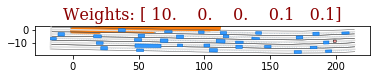

In [48]:
xf = np.reshape(sol.x, (len(x0) // 2, 2))
print(np.array(nl_opt).shape)

plt.figure()
font = {'family': 'serif',
        'color': 'darkred',
        'weight': 'normal',
        'size': 16,
        }
w_new = np.array2string(w)
plt.title('Weights: ' + w_new, fontdict=font)
x0_c = np.reshape(x0, (len(x0)//2, 2))
plt.plot(x0_c[:, 0], x0_c[:, 1], '-x')
plt.plot(xf[:, 0], xf[:, 1], '-o')

draw_object(new_sim.scenario)
draw_object(final_state)
plt.gca().set_aspect('equal')
# plt.savefig(os.getcwd() + "/solution_pic/" + name + ".png")
plt.show()


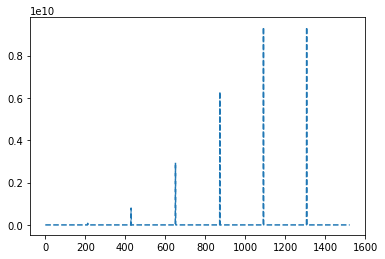

In [49]:
plt.figure()
plt.plot(range(len(_costs)), _costs,'--')
plt.show()

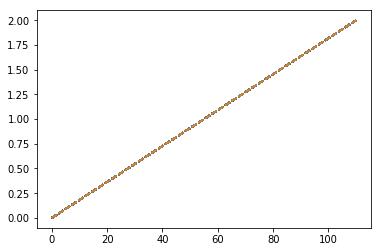

In [44]:
plt.figure()
for i in np.array(nl_opt):
    plt.plot(i[:, 0], i[:, 1], '--')

plt.show()